In [1]:
# importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


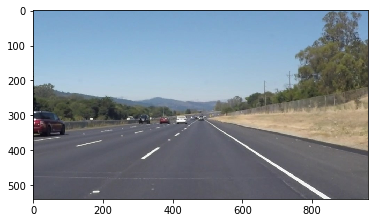

In [2]:
#reading in an image
dir_img = 'test_images/'
image = mpimg.imread('test_images/solidWhiteRight.jpg')#RGB
#print out some stats and plotting
print('This image is:',type(image),'with dimensions:',image.shape)
plt.imshow(image)

## 车道线检测的一些思路
opencv库为我们提供了一些有用的函数：
cv2.inRange():颜色选择
cv2.fillpoly():区域选择
cv2.line():给定一些端点在图片上画出线
cv2.addWeighted():添加或覆盖两个图像
cv2.cvtColor():转换成灰度图或者改变图像颜色
cv2.imwrite():将图片输出到文件
cv2.bitwise_and():在图片上应用蒙板
## 接下来我们实现一些辅助函数 

In [3]:
import math

def grayscale(img):
    '''
    灰度转换，返回只有一个颜色通道的图像
    '''
    return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)#if you read an image with cv.imread(),return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

def canny(img,low_threshold,high_threshold):
    return cv2.Canny(img,low_threshold,high_threshold)

def gaussian_blur(img,kernel_size):
    '''Applies a Gaussian Noise Kernel'''#高斯模糊
    return cv2.GaussianBlur(img,(kernel_size,kernel_size),0)

def region_of_interest(img,vertices):
    '''
    Apply an image mask
    
    '''
    #define a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape)>2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,)*channel_count
    else: 
        ignore_mask_color = 255#涂黑
    
    cv2.fillPoly(mask,vertices,ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img,mask)#与操作
    return masked_image 

def draw_lines(img,lines,color=[255,0,0],thickness=2):
    '''
    Note: 
    '''
    #print(lines)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img,(x1,y1),(x2,y2),color,thickness)

def hpass_angle_filter(lines,angle_threshold):
    if lines.shape!=None:
        filtered_lines =[]
        for line in lines:
            for x1,y1,x2,y2 in line:
                angle = abs(np.arctan((y2-y1)/(x2-x1))*180/np.pi)
                if angle > angle_threshold:
                    filtered_lines.append([[x1,y1,x2,y2]])
        return filtered_lines
def average_lines(img,lines,y_min,y_max):
    #return coordinates of the averaged lines
    hough_pts = {'m_left':[],'b_left':[],'norm_left':[],'m_right':[],'b_right':[],'norm_right':[]}
    if lines != None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                m,b = np.polyfit([x1,x2],(y1,y2),1)
                norm = ((x2-x1)**2+(y2-y1)**2)**0.5
                if m>0:#斜率right
                    hough_pts['m_right'].append(m)
                    hough_pts['b_right'].append(b)
                    hough_pts['norm_right'].append(norm)
                if m<0:
                    hough_pts['m_left'].append(m)
                    hough_pts['b_left'].append(b)
                    hough_pts['norm_left'].append(norm)
    if len(hough_pts['b_left'])!=0 or len(hough_pts['m_left'])!=0 or len(hough_pts['norm_left'])!=0:
        b_avg_left = np.mean(np.array(hough_pts['b_left']))
        m_avg_left = np.mean(np.array(hough_pts['m_left']))
        xmin_left = int((y_min-b_avg_left)/m_avg_left)
        xmax_left = int((y_max-b_avg_left)/m_avg_left)
        left_lane = [[xmin_left,y_min,xmax_left,y_max]]
    else:
        left_lane = [[0,0,0,0]]
    if len(hough_pts['b_right'])!=0 or len(hough_pts['m_right'])!=0 or len(hough_pts['norm_right'])!=0:
        b_avg_right = np.mean(np.array(hough_pts['b_right']))
        m_avg_right = np.mean(np.array(hough_pts['m_right']))
        xmin_right = int((y_min - b_avg_right)/m_avg_right)
        xmax_right = int((y_max-b_avg_right)/m_avg_right)
        right_lane = [[xmin_right,y_min,xmax_right,y_max]]
    else:
        right_lane = [[0,0,0,0]]
    return [left_lane,right_lane]

        
def hough_lines(img,rho,theta,threshold,min_line_len,max_line_gap):
    '''
    img is the output of canny tranform
    return an image with hough lines draw
    '''
    lines = cv2.HoughLinesP(img,rho,theta,threshold,np.array([]),minLineLength=min_line_len,maxLineGap = max_line_gap)
    #print(lines.shape)
    #line_img = np.zeros((img.shape[0],img.shape[1],3),dtype=np.uint8)
    '''
    line2 = []
    try:
        for line in lines:
            for x1,y1,x2,y2 in line:
                if abs(y1-y2)<10:
                    continue
                k = float(y2-y1)/(x2-x1)
                if y1>y2:
                    extend = int(x2+(img.shape[0]-y2)/k)
                    lines2.append([x2-x1,y1,k,extend])
        lines2 = np.array(lines2)
        lines3 = []
        for side in [lines2[lines2[:,2]<0],lines2[lines2[:,2]>0]]:
            h2 = side[:,1].min()
            side[:,0]/=side[:,0].min()
            k1 = np.average(side[:,2],weights=side[:,0])
            x1 = np.average(side[:,3],weights=side[:,0])
            lines3.append([int(x1),img.shape[0],int(x1-(img.shape[0]-h2)/k1),int(h2)])
        arr+=np.array(lines3)
    except:
        pass
    lines4 = arr.data.mean(axis=0)
    draw_lines(line_img,[lines4])
    '''
    #draw_lines(line_img,lines)
    return lines

def weighted_img(img,initial_img,a=0.8,b=1,r=0.0):
    return cv2.addWeighted(initial_img,a,img,b,r)

## test images
接下来，我们来对一些图片做个测试

In [4]:
import os
dir_img = 'test_images/'
f = os.listdir(dir_img)

Image: solidYellowCurve2.jpg


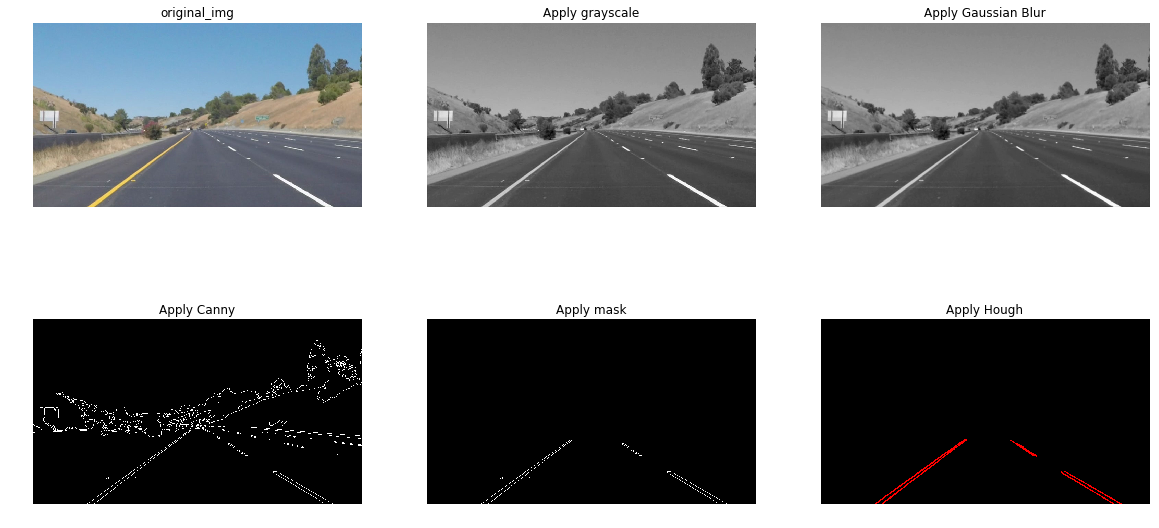

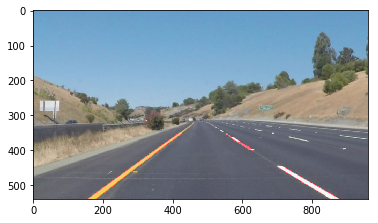

Image: solidYellowCurve.jpg


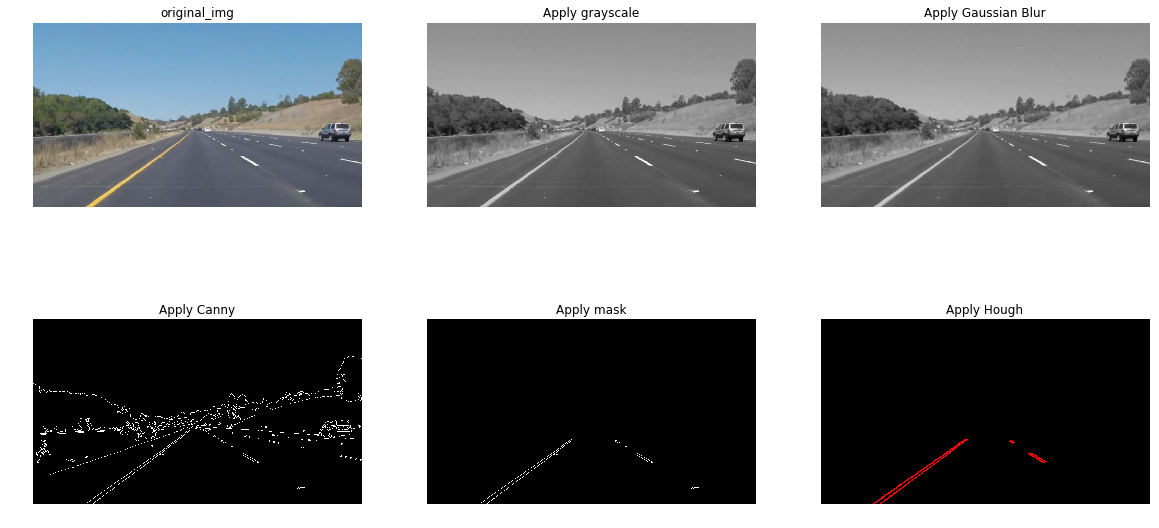

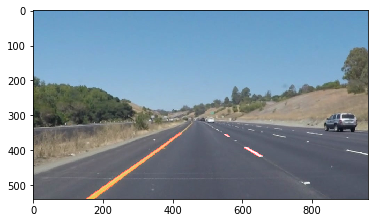

Image: solidWhiteCurve.jpg


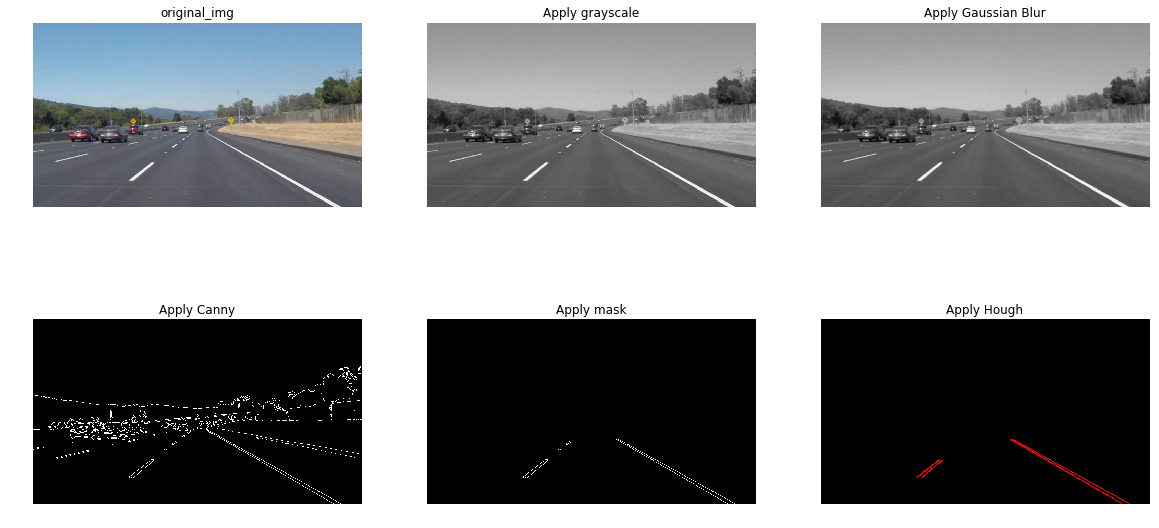

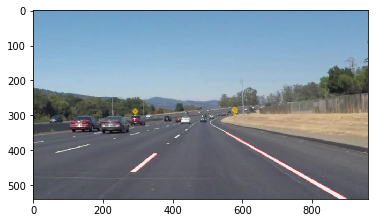

Image: solidWhiteRight.jpg


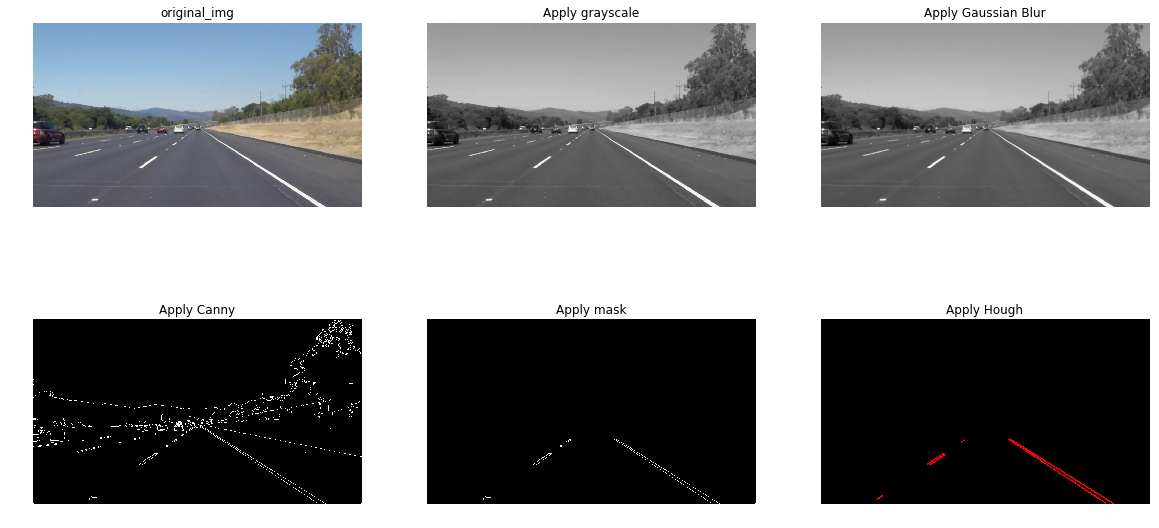

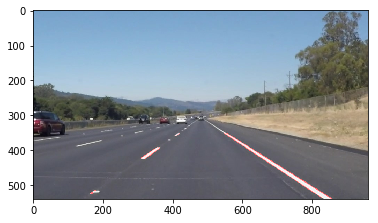

Image: whiteCarLaneSwitch.jpg


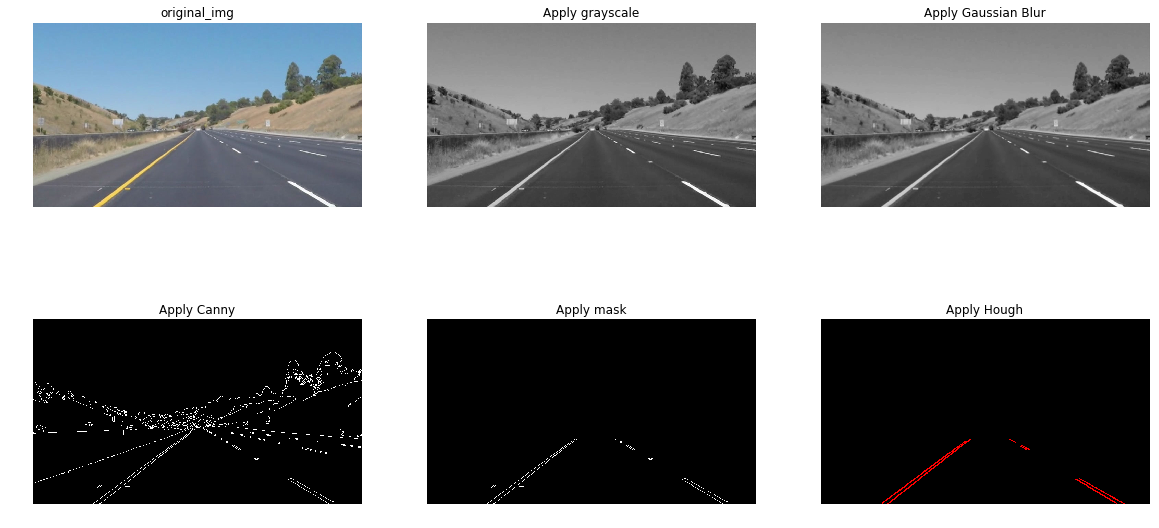

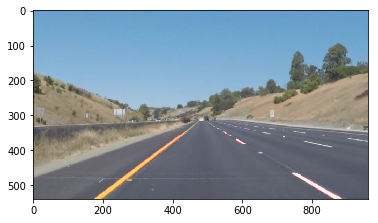

Image: solidYellowLeft.jpg


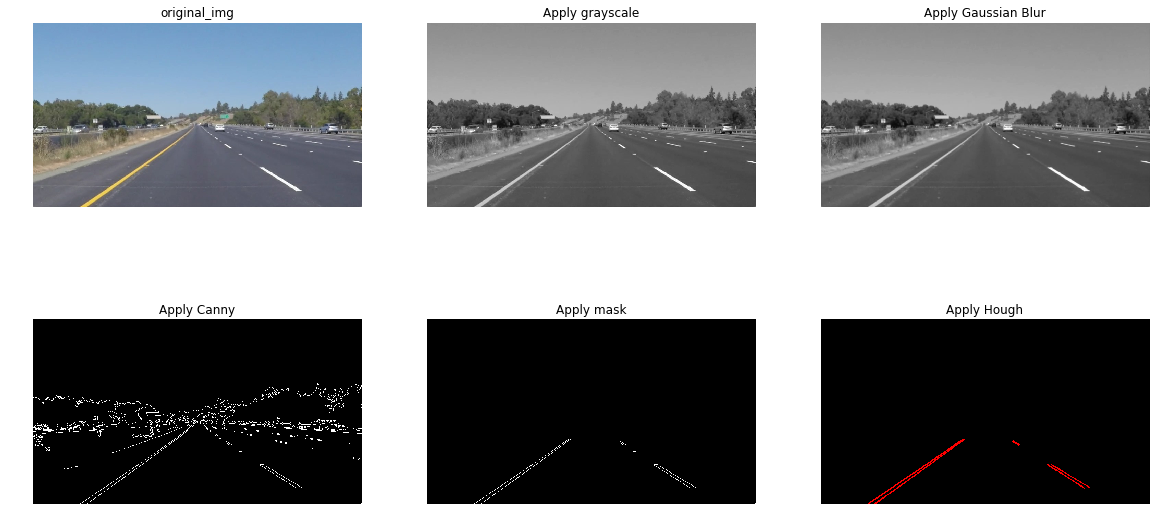

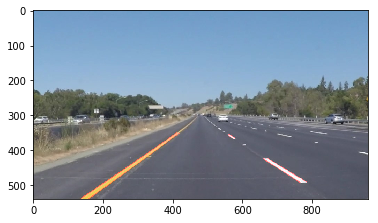

In [5]:
f = [fname for fname in f if 'jpeg' in  fname or 'jpg' in fname]

def show_img(ax,img,cmap,title):
    if cmap=='gray':
        ax.imshow(img,cmap='gray')
    else:
        ax.imshow(img)
    ax.axis('off')
    ax.set_title(title)
def pipeline(img,vertices,threshold_angle,hline_show):
    '''
    pipeline:
    
    '''
    # convert to grayscale
    gray = grayscale(img)
    # Apply Gaussian Blur:noise smooth noise
    gray_blur = gaussian_blur(gray,3)
    # Apply canny edge detector
    edges = canny(gray_blur,10,180)#这个阈值的选取，主要靠经验
    # apply mask 
    imshape = img.shape
    masked = region_of_interest(edges,vertices)
    h_lines = hough_lines(masked,rho=1,theta=np.pi/180,threshold=25,min_line_len=10,max_line_gap=10)#检测直线
    #Hough Tramsform lines
    if hline_show['hlines']=='on':
        hlines_img = np.zeros(imshape,dtype=np.uint8)
        draw_lines(hlines_img,h_lines,color=[255,0,0],thickness=2)
    else:
        hlines_img = np.zeros(imshape,dtype=np.uint8)
    #Angle High Pass filter
    h_lines = hpass_angle_filter(h_lines,threshold_angle)
    # average lines
    if hline_show['avg']=='on':
        avg_hlines = average_lines(img,h_lines,int(img.shape[0]*0.65),img.shape[0])
        avg_img = np.zeros(imshape,dtype=np.uint8)
        draw_lines(avg_img,avg_hlines,color=[255,0,0],thickness=10)
    else:
        avg_img = np.zeros(imshape,dtype=np.uint8)
    #Display result of each step of the pipeline
    if hline_show['steps']=='on':
        _,ax = plt.subplots(2,3,figsize=(20,10))
        show_img(ax[0,0],img,None,'original_img')
        show_img(ax[0,1],gray,'gray','Apply grayscale')
        show_img(ax[0,2],gray_blur,'gray','Apply Gaussian Blur')
        show_img(ax[1,0],edges,'gray','Apply Canny')
        show_img(ax[1,1],masked,'gray','Apply mask')
        show_img(ax[1,2],hlines_img,None,'Apply Hough')
        plt.show()
    
    img_all_lines = weighted_img(hlines_img,img,a=1,b=0.8,r=0.0)#计算两个矩阵的权重和
    img_all_lines = weighted_img(avg_img,img_all_lines,a=1,b=0.8,r=0.0)
    return img_all_lines

for img_name in f:
    #reading in an imag
    print('Image:',img_name)
    img = mpimg.imread(dir_img+img_name)
    hline_show = {'hlines':'on','avg':'off','steps':'on'}
    imshape = img.shape
    # vertices 圈定了车道线的范围
    vertices = np.array([[(100,imshape[0]),(390,imshape[0]*0.65),\
                         (620,imshape[0]*0.65),(imshape[1],imshape[0]),\
                         (100,imshape[0])]],dtype=np.int32)
    threshold_angle = 25
    lines_img = pipeline(img,vertices,threshold_angle,hline_show)
    plt.imshow(lines_img)
    plt.show()

## test on video
接下来我们来看看在视频上处理的效果
我们需要在视频上画出车道线

In [6]:
import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    #返回值必须是一个三通道的彩色图像
    hline_show = {'hlines':'on','avg':'on','steps':'off'}
    imshape = img.shape
    vertices = np.array([[(100,imshape[0]),(390,imshape[0]*0.65),\
                         (620,imshape[0]*0.65),(imshape[1],imshape[0]),\
                         (100,imshape[0])]],dtype=np.int32)
    threshold_angle = 25
    return pipeline(image,vertices,threshold_angle,hline_show)

In [8]:
dir_video = 'test_videos/'
white_output = dir_video+'white.mp4'
clip1 = VideoFileClip(dir_video+'solidWhiteRight.mp4')
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output,audio=False)

[MoviePy] >>>> Building video test_videos/white.mp4
[MoviePy] Writing video test_videos/white.mp4


100%|█████████▉| 221/222 [00:02<00:00, 77.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/white.mp4 

CPU times: user 1.99 s, sys: 125 ms, total: 2.12 s
Wall time: 3.07 s


In [9]:
HTML('''
<video width='960' height='540' controls>
<source src =white_output>
</video>
''')

## Imporvement
接下来我们来看看一些值得改善与提高的地方：
我们知道，车道线检测算法的性能受道路上的一些“噪声”的影响，比如说阴影、道路损坏等。
有些断断续续的路段可以通过高通滤波器来连接。但是算法并不适用于跟踪弯曲车道线
因此我们从以下三个方面来提高算法的性能：
>* 角度滤波器：滤除极小锐角或极大钝角的线段
>* 选取黄色的色调，并用白色代替
>* 在边缘检测前，放大一些特征

In [10]:
def bypass_angle_filter(lines,low_thres,hi_thres):
    '''
    前面的代码中，我们也实现了一个角度滤波器，但是这两个函数还是有区别的，
    前面的函数只有一个阈值，而这个函数有两个阈值，并只保留阈值之间的角度
    '''
    filtered_lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            angle = abs(np.arctan((y2-y1)/(x2-x1))*180/np.pi)
            if angle > low_thres and angle < hi_thres:
                filtered_lines.append([[x1,y1,x2,y2]])
    return filtered_lines

def yellow_enhance(img_rgb):
    '''
    该函数将rgb中淡黄色转换成白色，主要分三步：
    step1:convert rgb to hsv
    step2:create a lower/upper range of hsv
    step3:create a mask
    '''
    img_hsv = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([40,100,20])
    upper_yellow = np.array([100,255,255])
    mask = cv2.inRange(img_hsv,lower_yellow,upper_yellow)
    gray = grayscale(img_rgb)
    return weighted_img(mask,gray,a=1.,b=1.,r=0.)

def pipeline(img,vertices,low_thres,hi_thres,hline_show):
    #convert to grayscale + enhance yellow-ish tone
    gray = yellow_enhance(img)
    #remove /cleanup noise
    gray_blur = gaussian_blur(gray,3)
    # dilate features for large gap between edges line
    gray =cv2.dilate(gray,(3,3),iterations=10)
    
    edges = canny(gray,50,180)
    imshape = img.shape
    masked = region_of_interest(edges,vertices)
    
    h_lines = hough_lines(masked,rho=1,theta=np.pi/180,threshold=26,min_line_len=5,max_line_gap=50)
    
    if hline_show['hlines']=='on':
        hlines_img = np.zeros(imshape,dtype=np.uint8)
        draw_lines(hlines_img,h_lines,color=[255,0,0],thickness=4)
    else:
        hlines_img = np.zeros(imshape,dtype=np.uint8)
    # Angle High Pass filter
    h_lines = bypass_angle_filter(h_lines,low_thres,hi_thres)
    
    #averaging lines
    if hline_show['avg'] == 'on':
        avg_hlines = average_lines(img,h_lines,int(img.shape[0]*0.65),img.shape[0])
        avg_img = np.zeros(imshape,dtype=np.uint8)
        draw_lines(avg_img,avg_hlines,color=[255,0,0],thickness=10)
    else:
        avg_img = np.zeros(imshape,dtype=np.uint8)
    #Display result of each step of the pipeline
    if hline_show['steps']=='on':
        _,ax = plt.subplots(2,3,figsize=(20,10))
        show_img(ax[0,0],img,None,'original_img')
        show_img(ax[0,1],gray,'gray','Apply grayscale')
        show_img(ax[0,2],gray_blur,'gray','Apply Gaussian Blur')
        show_img(ax[1,0],edges,'gray','Apply Canny')
        show_img(ax[1,1],masked,'gray','Apply mask')
        show_img(ax[1,2],hlines_img,None,'Apply Hough')
        plt.show()
    img_all_lines = weighted_img(hlines_img,img,a=1.,b=0.8,r=0.)
    img_all_lines = weighted_img(avg_img,img_all_lines,a=1.,b=0.8,r=0.)
    return img_all_lines

In [11]:
def process_image(image):
    hline_show = {'hlines':'off','avg':'on','steps':'off'}
    imshape = [720,1280]
    vertices = np.array([[(200,imshape[0]-80),(490,imshape[0]*0.65),\
                         (820,imshape[0]*0.65),(imshape[1]-150,imshape[0]-80),\
                         (100,imshape[0]-80)]],dtype=np.int32)
    low_thres,hi_thres = [30,80]
    return pipeline(image,vertices,low_thres,hi_thres,hline_show)

In [12]:
challenge_output = dir_video +'extra.mp4'
clip2 = VideoFileClip(dir_video+'challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output,audio=False)

[MoviePy] >>>> Building video test_videos/extra.mp4
[MoviePy] Writing video test_videos/extra.mp4


100%|██████████| 251/251 [00:06<00:00, 37.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/extra.mp4 

CPU times: user 5.55 s, sys: 213 ms, total: 5.77 s
Wall time: 7.43 s
